<h1 align='center'>  Fake news classifier using Machine Learning </h1>

## Table of Contents

<details open>
<summary>Show/Hide</summary>
<br>

1. [Introduction: Business Problem](#introduction)
2. [Data](#data)
3. [Methodology](#methodology)
4. [Analysis](#analysis)
5. [Results and Discussion](#results)
6. [Conclusion](#conclusion)
</details>

## Introduction: Business Problem

<details>
<a name="#introduction"></a>
<summary>Show/Hide</summary>
<br>
Detection of fake news online is important in today's society as fresh news content is rapidly being produced as a result of the abundance of technology that is present. Fake news is nothing new. But, what is new is how easy it's become to share information – both true and false – on a massive scale.

Social media platforms allow almost anyone to publish their thoughts or share stories to the world. The trouble is, most people don't check the source of the material that they view online before they share it, which can lead to fake news spreading quickly or even "going viral."

Our work will consist of building a fake news classifier using machine learning.

We are part of the #sg_spanish group @ Íñigo Lejarza @Cesar S. @Stanley Salvatierra @ ketcx @susyjam @Fernando T<br>
<br>
</details>

## Data

<details>
<a name="#data"></a>
<summary>Show/Hide</summary>
<br>
The data used comes from Kaggle. Kaggle's dataset contains true and false news articles from 2015 to 2018.

https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset
</details>

## Import libraries

In [1]:
!pip install --upgrade tensorflow-gpu==2.0

Requirement already up-to-date: tensorflow-gpu==2.0 in /anaconda/envs/azureml_py36/lib/python3.6/site-packages (2.0.0)


In [7]:
!conda install -c plotly plotly --yes
!pip install --upgrade nbformat
!pip install nltk
!pip install spacy
!pip install WordCloud
!pip install gensim 
!pip install seaborn
!pip install jupyterthemes

Traceback (most recent call last):
  File "/anaconda/envs/azureml_py36/bin/conda", line 7, in <module>
    from conda.cli import main
ModuleNotFoundError: No module named 'conda'
Requirement already up-to-date: nbformat in /anaconda/envs/azureml_py36/lib/python3.6/site-packages (5.0.7)
     |████████████████████████████████| 7.0 MB 14.8 MB/s eta 0:00:01
     |████████████████████████████████| 46 kB 1.8 MB/s  eta 0:00:01
     |████████████████████████████████| 49 kB 1.8 MB/s  eta 0:00:01


In [8]:
import nltk
nltk.download('punkt')

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from nltk import word_tokenize
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False) 

[nltk_data] Downloading package punkt to /home/azureuser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Import Datasets

In [9]:
df_true = pd.read_csv("True.csv")
df_fake = pd.read_csv("Fake.csv")

### Exploratory Analysis

In [10]:
print("We have {} true news and {} fake news \n".format(len(df_true.index), len(df_fake.index)))
print("Null elements for true news:\n{} \n\nNull elements for fake news:\n{}".format(df_true.isna().sum(), df_fake.isna().sum()))


We have 21417 true news and 23481 fake news 

Null elements for true news:
title      0
text       0
subject    0
date       0
dtype: int64 

Null elements for fake news:
title      0
text       0
subject    0
date       0
dtype: int64


In [11]:
df_true['isfake'] = 0
df_true.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  isfake  
0  December 31, 2017        0  
1  December 29, 2017        0  
2  December 31, 2017        0  
3  December 30, 2017        0  
4  December 29, 2017        0

In [12]:
df_fake['isfake'] = 1
df_fake.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  isfake  
0  December 31, 2017       1  
1  December 31, 2017       1  
2  December 30, 2017       1  
3  December 29, 2017       1  
4  December 25, 2017       1

In [14]:
# Merge Real and Fake News
df = pd.concat([df_true, df_fake]).reset_index(drop = True)
df

title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
5      White House, Congress prepare for talks on spe...   
6      Trump says Russia probe will be fair, but time...   
7      Factbox: Trump on Twitter (Dec 29) - Approval ...   
8             Trump on Twitter (Dec 28) - Global Warming   
9      Alabama official to certify Senator-elect Jone...   
10     Jones certified U.S. Senate winner despite Moo...   
11     New York governor questions the constitutional...   
12     Factbox: Trump on Twitter (Dec 28) - Vanity Fa...   
13        Trump on Twitter (Dec 27) - Trump, Iraq, Syria   
14     Man says he delivered manure to Mnuchin to pro...   
15     Virginia officials postpone lottery drawing to...   
16     U.S. lawmakers question businessman at 2016 Tr...   
17     Trump on Twitter (Dec 26) - Hillary Clinton, T...   
18     U.S. appeals court rejects challenge to Trump ...   
19     Treasury Secretary Mnuchin was sent gift-wrapp...   
20     Federal judge partially lifts Trump's latest r...   
21     Exclusive: U.S. memo weakens guidelines for pr...   
22     Trump travel ban should not apply to people wi...   
23     Second court rejects Trump bid to stop transge...   
24     Failed vote to oust president shakes up Peru's...   
25     Trump signs tax, government spending bills int...   
26     Companies have up to a year for new U.S. tax b...   
27     Trump on Twitter (Dec 22) - Tax cut, Missile d...   
28     Mexico to review need for tax changes after U....   
29     Senate leader McConnell sees a more collegial ...   
...                                                  ...   
44868  3.57 Degrees: Kevin Bacon’s Cultural Mantle Sh...   
44869           Bernie Sanders Could End Up Winning Iowa   
44870  Plastic Persona: Behind the Scenes of the Ted ...   
44871          ‘Meet Jeb’ – Going For Your Sympathy Vote   
44872  BOILER ROOM – Examination, Exclamation, Excita...   
44873  Eyewash: CIA Elites Misleading Employees Indic...   
44874  Activist: ‘This is where you can make the most...   
44875  Episode #120 – SUNDAY WIRE: ‘Crisis of Liberty...   
44876  FBI Release Oregon Video Footage Depicting Dea...   
44877  Trial By YouTube: Mainstream Media Use Second-...   
44878  REPORT: ‘Federal Government Escalated the Viol...   
44879  BOILER ROOM – Oregon Standoff, Cuddle Parties,...   
44880  Eyewitness Says Feds Ambushed Bundys, 100 Shot...   
44881  Episode #119 – SUNDAY WIRE: ‘You Know the Dril...   
44882  ‘There’ll be boots on the ground’: US making n...   
44883  Boston Brakes? How to Hack a New Car With Your...   
44884  Oregon Governor Says Feds ‘Must Act’ Against P...   
44885  Ron Paul on Burns Oregon Standoff and Jury Nul...   
44886     BOILER ROOM: As the Frogs Slowly Boil – EP #40   
44887  Arizona Rancher Protesting in Oregon is Target...   
44888  Seven Iranians freed in the prisoner swap have...   
44889                      #Hashtag Hell & The Fake Left   
44890  Astroturfing: Journalist Reveals Brainwashing ...   
44891          The New American Century: An Era of Fraud   
44892  Hillary Clinton: ‘Israel First’ (and no peace ...   
44893  McPain: John McCain Furious That Iran Treated ...   
44894  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896  How to Blow $700 Million: Al Jazeera America F...   
44897  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2      WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3      WASHINGTON (Reuters) - Trum

In [15]:
df.drop(columns = ['date'], inplace = True)

In [16]:
# merge title and text together
df['original'] = df['title'] + ' ' + df['text']
df.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  isfake  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews       0   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews       0   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews       0   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews       0   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews       0   

                                            original  
0  As U.S. budget fight looms, Republicans flip t...  
1  U.S. military to accept transgender recruits o...  
2  Senior U.S. Republican senator: 'Let Mr. Muell...  
3  FBI Russia probe helped by Australian diplomat...  
4  Trump wants Postal Service to charge 'much mor...

In [17]:
df['original'][0]

'As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non

### Data cleaning

In [18]:
nltk.download("stopwords")

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [19]:
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [20]:
# Remove stopwords and remove words with 3 or less characters
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)
            
    return result

In [22]:
df['clean'] = df['original'].apply(preprocess)
df['original'][4]

"Trump wants Postal Service to charge 'much more' for Amazon shipments SEATTLE/WASHINGTON (Reuters) - President Donald Trump called on the U.S. Postal Service on Friday to charge “much more” to ship packages for Amazon (AMZN.O), picking another fight with an online retail giant he has criticized in the past.     “Why is the United States Post Office, which is losing many billions of dollars a year, while charging Amazon and others so little to deliver their packages, making Amazon richer and the Post Office dumber and poorer? Should be charging MUCH MORE!” Trump wrote on Twitter.  The president’s tweet drew fresh attention to the fragile finances of the Postal Service at a time when tens of millions of parcels have just been shipped all over the country for the holiday season.  The U.S. Postal Service, which runs at a big loss, is an independent agency within the federal government and does not receive tax dollars for operating expenses, according to its website.  Package delivery has 

In [23]:
print(df['clean'][4])

['trump', 'wants', 'postal', 'service', 'charge', 'amazon', 'shipments', 'seattle', 'washington', 'reuters', 'president', 'donald', 'trump', 'called', 'postal', 'service', 'friday', 'charge', 'ship', 'packages', 'amazon', 'amzn', 'picking', 'fight', 'online', 'retail', 'giant', 'criticized', 'past', 'united', 'states', 'post', 'office', 'losing', 'billions', 'dollars', 'year', 'charging', 'amazon', 'little', 'deliver', 'packages', 'making', 'amazon', 'richer', 'post', 'office', 'dumber', 'poorer', 'charging', 'trump', 'wrote', 'twitter', 'president', 'tweet', 'drew', 'fresh', 'attention', 'fragile', 'finances', 'postal', 'service', 'time', 'tens', 'millions', 'parcels', 'shipped', 'country', 'holiday', 'season', 'postal', 'service', 'runs', 'loss', 'independent', 'agency', 'federal', 'government', 'receive', 'dollars', 'operating', 'expenses', 'according', 'website', 'package', 'delivery', 'increasingly', 'important', 'business', 'internet', 'sharp', 'decline', 'class', 'letters', 'pre

In [24]:
df

title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
5      White House, Congress prepare for talks on spe...   
6      Trump says Russia probe will be fair, but time...   
7      Factbox: Trump on Twitter (Dec 29) - Approval ...   
8             Trump on Twitter (Dec 28) - Global Warming   
9      Alabama official to certify Senator-elect Jone...   
10     Jones certified U.S. Senate winner despite Moo...   
11     New York governor questions the constitutional...   
12     Factbox: Trump on Twitter (Dec 28) - Vanity Fa...   
13        Trump on Twitter (Dec 27) - Trump, Iraq, Syria   
14     Man says he delivered manure to Mnuchin to pro...   
15     Virginia officials postpone lottery drawing to...   
16     U.S. lawmakers question businessman at 2016 Tr...   
17     Trump on Twitter (Dec 26) - Hillary Clinton, T...   
18     U.S. appeals court rejects challenge to Trump ...   
19     Treasury Secretary Mnuchin was sent gift-wrapp...   
20     Federal judge partially lifts Trump's latest r...   
21     Exclusive: U.S. memo weakens guidelines for pr...   
22     Trump travel ban should not apply to people wi...   
23     Second court rejects Trump bid to stop transge...   
24     Failed vote to oust president shakes up Peru's...   
25     Trump signs tax, government spending bills int...   
26     Companies have up to a year for new U.S. tax b...   
27     Trump on Twitter (Dec 22) - Tax cut, Missile d...   
28     Mexico to review need for tax changes after U....   
29     Senate leader McConnell sees a more collegial ...   
...                                                  ...   
44868  3.57 Degrees: Kevin Bacon’s Cultural Mantle Sh...   
44869           Bernie Sanders Could End Up Winning Iowa   
44870  Plastic Persona: Behind the Scenes of the Ted ...   
44871          ‘Meet Jeb’ – Going For Your Sympathy Vote   
44872  BOILER ROOM – Examination, Exclamation, Excita...   
44873  Eyewash: CIA Elites Misleading Employees Indic...   
44874  Activist: ‘This is where you can make the most...   
44875  Episode #120 – SUNDAY WIRE: ‘Crisis of Liberty...   
44876  FBI Release Oregon Video Footage Depicting Dea...   
44877  Trial By YouTube: Mainstream Media Use Second-...   
44878  REPORT: ‘Federal Government Escalated the Viol...   
44879  BOILER ROOM – Oregon Standoff, Cuddle Parties,...   
44880  Eyewitness Says Feds Ambushed Bundys, 100 Shot...   
44881  Episode #119 – SUNDAY WIRE: ‘You Know the Dril...   
44882  ‘There’ll be boots on the ground’: US making n...   
44883  Boston Brakes? How to Hack a New Car With Your...   
44884  Oregon Governor Says Feds ‘Must Act’ Against P...   
44885  Ron Paul on Burns Oregon Standoff and Jury Nul...   
44886     BOILER ROOM: As the Frogs Slowly Boil – EP #40   
44887  Arizona Rancher Protesting in Oregon is Target...   
44888  Seven Iranians freed in the prisoner swap have...   
44889                      #Hashtag Hell & The Fake Left   
44890  Astroturfing: Journalist Reveals Brainwashing ...   
44891          The New American Century: An Era of Fraud   
44892  Hillary Clinton: ‘Israel First’ (and no peace ...   
44893  McPain: John McCain Furious That Iran Treated ...   
44894  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896  How to Blow $700 Million: Al Jazeera America F...   
44897  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2      WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3      WASHINGTON (Reuters) - Trum

In [25]:
list_of_words = []
for i in df.clean:
    for j in i:
        list_of_words.append(j)


In [26]:
list_of_words

['budget',
 'fight',
 'looms',
 'republicans',
 'flip',
 'fiscal',
 'script',
 'washington',
 'reuters',
 'head',
 'conservative',
 'republican',
 'faction',
 'congress',
 'voted',
 'month',
 'huge',
 'expansion',
 'national',
 'debt',
 'cuts',
 'called',
 'fiscal',
 'conservative',
 'sunday',
 'urged',
 'budget',
 'restraint',
 'keeping',
 'sharp',
 'pivot',
 'republicans',
 'representative',
 'mark',
 'meadows',
 'speaking',
 'face',
 'nation',
 'drew',
 'hard',
 'line',
 'federal',
 'spending',
 'lawmakers',
 'bracing',
 'battle',
 'january',
 'return',
 'holidays',
 'wednesday',
 'lawmakers',
 'begin',
 'trying',
 'pass',
 'federal',
 'budget',
 'fight',
 'likely',
 'linked',
 'issues',
 'immigration',
 'policy',
 'november',
 'congressional',
 'election',
 'campaigns',
 'approach',
 'republicans',
 'seek',
 'control',
 'congress',
 'president',
 'donald',
 'trump',
 'republicans',
 'want',
 'budget',
 'increase',
 'military',
 'spending',
 'democrats',
 'want',
 'proportional',
 '

In [27]:
len(list_of_words)

9276947

In [28]:
total_words = len(list(set(list_of_words)))
total_words

108704

In [29]:
df['clean_joined'] = df['clean'].apply(lambda x: " ".join(x))
df

title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
5      White House, Congress prepare for talks on spe...   
6      Trump says Russia probe will be fair, but time...   
7      Factbox: Trump on Twitter (Dec 29) - Approval ...   
8             Trump on Twitter (Dec 28) - Global Warming   
9      Alabama official to certify Senator-elect Jone...   
10     Jones certified U.S. Senate winner despite Moo...   
11     New York governor questions the constitutional...   
12     Factbox: Trump on Twitter (Dec 28) - Vanity Fa...   
13        Trump on Twitter (Dec 27) - Trump, Iraq, Syria   
14     Man says he delivered manure to Mnuchin to pro...   
15     Virginia officials postpone lottery drawing to...   
16     U.S. lawmakers question businessman at 2016 Tr...   
17     Trump on Twitter (Dec 26) - Hillary Clinton, T...   
18     U.S. appeals court rejects challenge to Trump ...   
19     Treasury Secretary Mnuchin was sent gift-wrapp...   
20     Federal judge partially lifts Trump's latest r...   
21     Exclusive: U.S. memo weakens guidelines for pr...   
22     Trump travel ban should not apply to people wi...   
23     Second court rejects Trump bid to stop transge...   
24     Failed vote to oust president shakes up Peru's...   
25     Trump signs tax, government spending bills int...   
26     Companies have up to a year for new U.S. tax b...   
27     Trump on Twitter (Dec 22) - Tax cut, Missile d...   
28     Mexico to review need for tax changes after U....   
29     Senate leader McConnell sees a more collegial ...   
...                                                  ...   
44868  3.57 Degrees: Kevin Bacon’s Cultural Mantle Sh...   
44869           Bernie Sanders Could End Up Winning Iowa   
44870  Plastic Persona: Behind the Scenes of the Ted ...   
44871          ‘Meet Jeb’ – Going For Your Sympathy Vote   
44872  BOILER ROOM – Examination, Exclamation, Excita...   
44873  Eyewash: CIA Elites Misleading Employees Indic...   
44874  Activist: ‘This is where you can make the most...   
44875  Episode #120 – SUNDAY WIRE: ‘Crisis of Liberty...   
44876  FBI Release Oregon Video Footage Depicting Dea...   
44877  Trial By YouTube: Mainstream Media Use Second-...   
44878  REPORT: ‘Federal Government Escalated the Viol...   
44879  BOILER ROOM – Oregon Standoff, Cuddle Parties,...   
44880  Eyewitness Says Feds Ambushed Bundys, 100 Shot...   
44881  Episode #119 – SUNDAY WIRE: ‘You Know the Dril...   
44882  ‘There’ll be boots on the ground’: US making n...   
44883  Boston Brakes? How to Hack a New Car With Your...   
44884  Oregon Governor Says Feds ‘Must Act’ Against P...   
44885  Ron Paul on Burns Oregon Standoff and Jury Nul...   
44886     BOILER ROOM: As the Frogs Slowly Boil – EP #40   
44887  Arizona Rancher Protesting in Oregon is Target...   
44888  Seven Iranians freed in the prisoner swap have...   
44889                      #Hashtag Hell & The Fake Left   
44890  Astroturfing: Journalist Reveals Brainwashing ...   
44891          The New American Century: An Era of Fraud   
44892  Hillary Clinton: ‘Israel First’ (and no peace ...   
44893  McPain: John McCain Furious That Iran Treated ...   
44894  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896  How to Blow $700 Million: Al Jazeera America F...   
44897  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2      WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3      WASHINGTON (Reuters) - Trum

In [30]:
df['clean_joined'][4]

'trump wants postal service charge amazon shipments seattle washington reuters president donald trump called postal service friday charge ship packages amazon amzn picking fight online retail giant criticized past united states post office losing billions dollars year charging amazon little deliver packages making amazon richer post office dumber poorer charging trump wrote twitter president tweet drew fresh attention fragile finances postal service time tens millions parcels shipped country holiday season postal service runs loss independent agency federal government receive dollars operating expenses according website package delivery increasingly important business internet sharp decline class letters president determine postal rates postal regulatory commission independent government agency commissioners selected president political parties panel raised prices packages percent november amazon founded jeff bezos remains chief executive officer retail company richest person world acc

## Analysis
<a name="#analysis"></a>

In [31]:
df

title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
5      White House, Congress prepare for talks on spe...   
6      Trump says Russia probe will be fair, but time...   
7      Factbox: Trump on Twitter (Dec 29) - Approval ...   
8             Trump on Twitter (Dec 28) - Global Warming   
9      Alabama official to certify Senator-elect Jone...   
10     Jones certified U.S. Senate winner despite Moo...   
11     New York governor questions the constitutional...   
12     Factbox: Trump on Twitter (Dec 28) - Vanity Fa...   
13        Trump on Twitter (Dec 27) - Trump, Iraq, Syria   
14     Man says he delivered manure to Mnuchin to pro...   
15     Virginia officials postpone lottery drawing to...   
16     U.S. lawmakers question businessman at 2016 Tr...   
17     Trump on Twitter (Dec 26) - Hillary Clinton, T...   
18     U.S. appeals court rejects challenge to Trump ...   
19     Treasury Secretary Mnuchin was sent gift-wrapp...   
20     Federal judge partially lifts Trump's latest r...   
21     Exclusive: U.S. memo weakens guidelines for pr...   
22     Trump travel ban should not apply to people wi...   
23     Second court rejects Trump bid to stop transge...   
24     Failed vote to oust president shakes up Peru's...   
25     Trump signs tax, government spending bills int...   
26     Companies have up to a year for new U.S. tax b...   
27     Trump on Twitter (Dec 22) - Tax cut, Missile d...   
28     Mexico to review need for tax changes after U....   
29     Senate leader McConnell sees a more collegial ...   
...                                                  ...   
44868  3.57 Degrees: Kevin Bacon’s Cultural Mantle Sh...   
44869           Bernie Sanders Could End Up Winning Iowa   
44870  Plastic Persona: Behind the Scenes of the Ted ...   
44871          ‘Meet Jeb’ – Going For Your Sympathy Vote   
44872  BOILER ROOM – Examination, Exclamation, Excita...   
44873  Eyewash: CIA Elites Misleading Employees Indic...   
44874  Activist: ‘This is where you can make the most...   
44875  Episode #120 – SUNDAY WIRE: ‘Crisis of Liberty...   
44876  FBI Release Oregon Video Footage Depicting Dea...   
44877  Trial By YouTube: Mainstream Media Use Second-...   
44878  REPORT: ‘Federal Government Escalated the Viol...   
44879  BOILER ROOM – Oregon Standoff, Cuddle Parties,...   
44880  Eyewitness Says Feds Ambushed Bundys, 100 Shot...   
44881  Episode #119 – SUNDAY WIRE: ‘You Know the Dril...   
44882  ‘There’ll be boots on the ground’: US making n...   
44883  Boston Brakes? How to Hack a New Car With Your...   
44884  Oregon Governor Says Feds ‘Must Act’ Against P...   
44885  Ron Paul on Burns Oregon Standoff and Jury Nul...   
44886     BOILER ROOM: As the Frogs Slowly Boil – EP #40   
44887  Arizona Rancher Protesting in Oregon is Target...   
44888  Seven Iranians freed in the prisoner swap have...   
44889                      #Hashtag Hell & The Fake Left   
44890  Astroturfing: Journalist Reveals Brainwashing ...   
44891          The New American Century: An Era of Fraud   
44892  Hillary Clinton: ‘Israel First’ (and no peace ...   
44893  McPain: John McCain Furious That Iran Treated ...   
44894  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896  How to Blow $700 Million: Al Jazeera America F...   
44897  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2      WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3      WASHINGTON (Reuters) - Trum

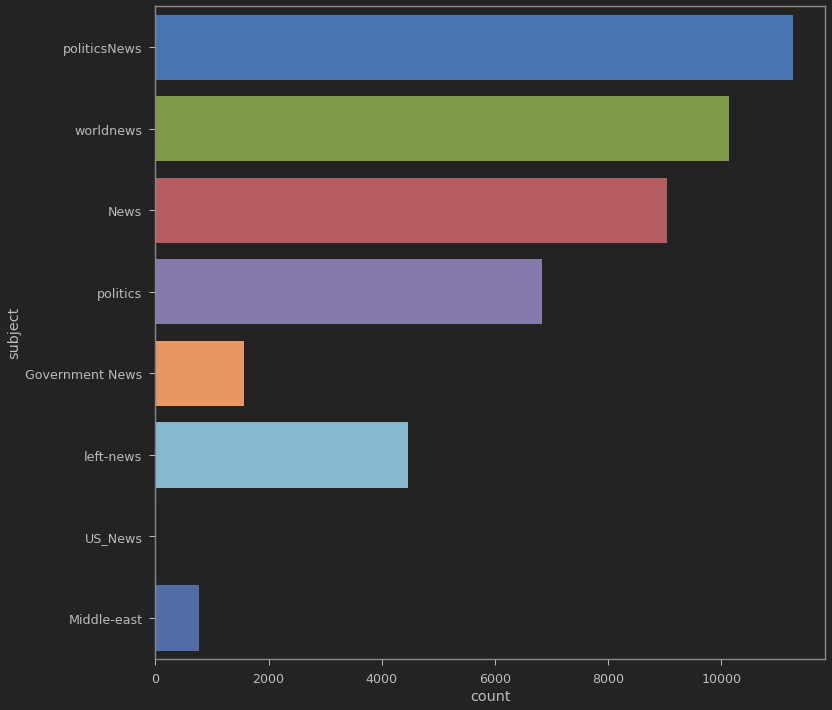

In [32]:
plt.figure(figsize = (12, 12))
sns.countplot(y = "subject", data = df)

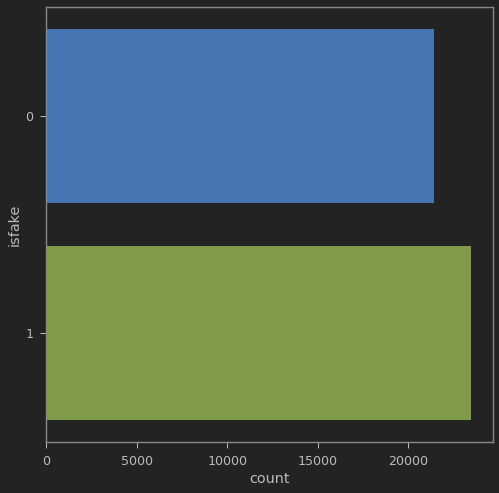

In [33]:
plt.figure(figsize = (8, 8))
sns.countplot(y = "isfake", data = df)

### Wordcloud for text that is Real

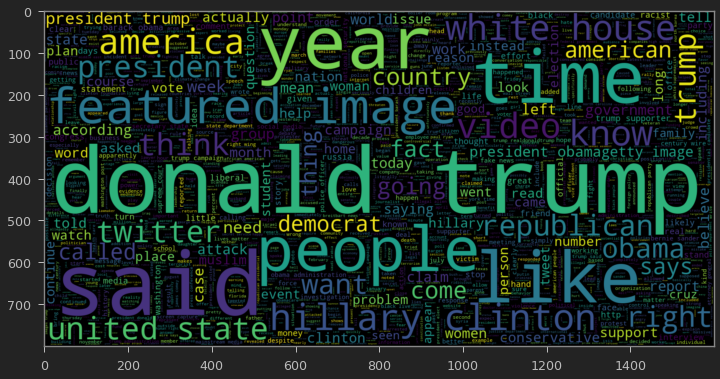

In [34]:
plt.figure(figsize = (12,12)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.isfake == 1].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')

### Wordcloud for text that is Fake

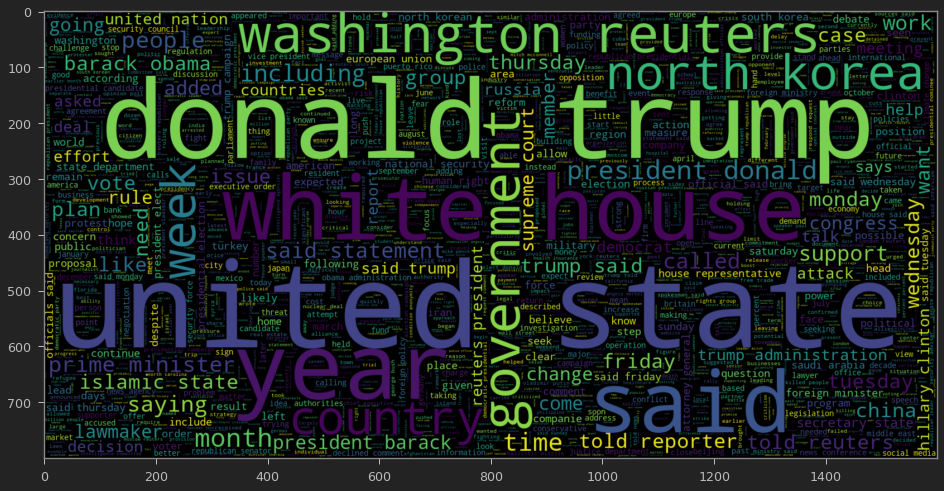

In [35]:
plt.figure(figsize = (16,16)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.isfake == 0].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')

In [36]:
maxlen = -1
for doc in df.clean_joined:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in any document is =", maxlen)

The maximum number of words in any document is = 4405


In [38]:
!pip install plotly
import plotly.express as px
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df.clean_joined], nbins = 100)
fig.show()

     |████████████████████████████████| 13.0 MB 4.7 MB/s eta 0:00:01
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11430 sha256=a756ae625dca5157807b83164e3e14bf9ed175b639252a8ab1a64c58187758da
  Stored in directory: /home/azureuser/.cache/pip/wheels/ac/cb/8a/b27bf6323e2f4c462dcbf77d70b7c5e7868a7fbe12871770cf
Successfully built retrying


### Tokenizing

In [39]:
# Test and train datasets

x_train, x_test, y_train, y_test = train_test_split(df.clean_joined, df.isfake, test_size = 0.3)

In [40]:
# Create a tokenizer to tokenize the words and create sequences of tokenized words
tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

In [41]:
len(test_sequences)

13470

In [42]:
len(train_sequences)

31428

In [43]:
print("The encoding for document\n",df.clean_joined[0],"\n is : ",train_sequences[0])

The encoding for document
 budget fight looms republicans flip fiscal script washington reuters head conservative republican faction congress voted month huge expansion national debt cuts called fiscal conservative sunday urged budget restraint keeping sharp pivot republicans representative mark meadows speaking face nation drew hard line federal spending lawmakers bracing battle january return holidays wednesday lawmakers begin trying pass federal budget fight likely linked issues immigration policy november congressional election campaigns approach republicans seek control congress president donald trump republicans want budget increase military spending democrats want proportional increases defense discretionary spending programs support education scientific research infrastructure public health environmental protection trump administration willing going increase defense discretionary spending percent meadows chairman small influential house freedom caucus said program democrats say

In [44]:
padded_train = pad_sequences(train_sequences,maxlen = 40, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences,maxlen = 40, truncating = 'post') 

In [45]:
for i,doc in enumerate(padded_train[:2]):
     print("The padded encoding for document",i+1," is : ",doc)

The padded encoding for document 1  is :  [  293   194   814   886  1810  3222     9   239    93  3483  1810     2
    71   293   120    64   194   814  1556   425   119 10306 14594 10013
  2369   886    82    18   250  2075   222  2561   250  2634  1810    17
     9   293   101    60]
The padded encoding for document 2  is :  [  206  3508  2214  1492 15153   585  2000   427  4746  6034   502 16111
    92  2214   121   412   581  5502 13518   212    49    92  1298   822
  3347   169  5113   631   778  1981  5848  4953   974  8980   125   439
 11852  9421 25755    76]



## Methodology

<details>
<a name="#methodology"></a>
<summary>Show/Hide</summary>
<br>
LSTM is a variant of Recurrent Neural Network (RNN) which has a memory cell. It performs better than vanilla RNN on long sequential data. LSTM was designed to overcome the vanishing gradient problem in RNN.

We are going to develop a Fake News Classifier using Long Short Term Memory (LSTM).
</details>


### Model

In [67]:
# Sequential Model
model = Sequential()

# embeddidng layer
model.add(Embedding(total_words, output_dim = 240))


# Bi-Directional RNN and LSTM
model.add(Bidirectional(LSTM(128)))

# Dense layers
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1,activation= 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 240)         26088960  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               377856    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 26,499,841
Trainable params: 26,499,841
Non-trainable params: 0
_________________________________________________________________


In [47]:
total_words

108704

In [48]:
y_train = np.asarray(y_train)

### Train the model

In [49]:
model.fit(padded_train, y_train, batch_size = 64, validation_split = 0.1, epochs = 2)

Train on 28285 samples, validate on 3143 samples
Epoch 1/2
28285/28285 [==============================] - 107s 4ms/sample - loss: 0.0403 - acc: 0.9878 - val_loss: 0.0053 - val_acc: 0.9994
Epoch 2/2
28285/28285 [==============================] - 101s 4ms/sample - loss: 0.0038 - acc: 0.9991 - val_loss: 0.0037 - val_acc: 0.9994


### Make prediction


In [51]:
# make prediction
pred = model.predict(padded_test)

### If the predicted value is > 0.5 it is real else it is fake

In [52]:
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)

In [53]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(list(y_test), prediction)

print("Model Accuracy : ", accuracy)

Model Accuracy :  0.9985152190051967


## Results and Discussion

<details>
<a name="#results"></a>
<summary>Show/Hide</summary>
<br>
We have trained our simple LSTM model on a fake news data set and obtained 90% accuracy. But we are aware that this may be better and that this model may not generalize in the best way.

One thing that can get stuck is trying to make a binary classifier with the Designer to measure and compare the results.
</details>


### Confusion matrix

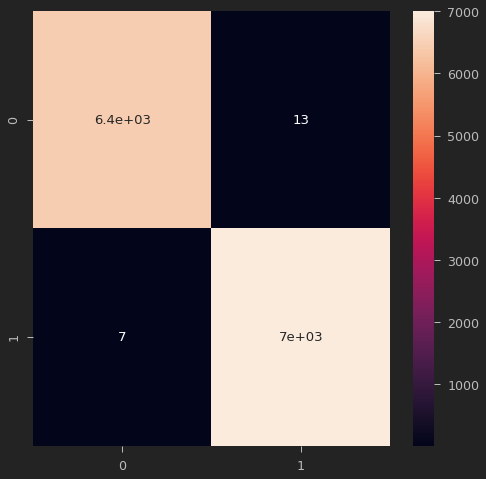

In [54]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(list(y_test), prediction)
plt.figure(figsize = (8, 8))
sns.heatmap(cm, annot = True)


## Conclusion

<details>
<a name="#conclusion"></a>
<summary>Show/Hide</summary>
<br>
With this classic exercise we can see the potential that machine learning has to solve real problems in our society.
</details>